In [1]:
import numpy as np
from scipy.stats import dirichlet
import copy
from scipy.special import kl_div
import torch
from scipy.stats import entropy
import scipy.stats as st
import seaborn as sns


import numpy as np
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer, load_diabetes
from sklearn import preprocessing

In [4]:
def prior(dim, s, lp):
    '''
    prior distribution is uniform distribution in the lp norm ball.
    '''
    s = np.power(s, lp)
    tmp_unif = np.random.uniform(0,s,size = dim)
    tmp_unif = np.sort(tmp_unif)
    tmp_unif = np.insert(tmp_unif, 0, 0)
    tmp_unif = np.insert(tmp_unif, dim+1, s)
    unif_ball = []
    for i in range(dim):
        sign = np.random.binomial(1,0.5) * 2 - 1
        unif_ball.append(sign * np.power((tmp_unif[i+1] - tmp_unif[i]), 1/lp))
    return np.array(unif_ball)

def priors(dim, s, N, lp):
    '''
    Concatenated prior distribution for N samples using prior function
    '''
    pri = np.zeros(shape = (N, dim))
    for i in range(N):
        pri[i, :] = prior(dim, s, lp)
    return pri

def generate_data(beta_true, data_num, sigma):
    '''
     data generation for synthetic dataset
    '''
    x = np.random.normal(0,1,size = (data_num, 2))
    noise = np.random.normal(0, sigma, size = (data_num, 1))
    y = x @ beta_true + noise
    return x, y.reshape(-1)


def gradient(beta, x, y, dim, batch, delta, s, lp):
    '''
    calculate the stochastic gradient with the penalized term
    '''
    f = np.zeros(shape = (dim))
    randomList=np.random.randint(0,len(y)-1,size=int(batch))
    for i in randomList:
        f=f-np.dot((y[i]-np.dot(beta,x[i])),x[i])/batch
    lp_norm = np.linalg.norm(beta, ord = lp)
    if lp_norm <= s:
        return f
    else:
#         print('reach boundary')
        g1 = np.power(np.abs(beta) / lp_norm, lp-1)
        tmp_con = (lp_norm-s) * np.multiply(g1, np.sign(beta))
        f = f + tmp_con / delta
        return f

def gradients(betas, x, y, dim, batch, delta, s, lp):
    '''
    Concatenated stochastic gradient for N samples using gradient function
    '''
    grads = np.zeros(shape = (len(betas), dim))
    for i in range(len(betas)):
        grads[i,:] = gradient(betas[i], x, y, dim, batch, delta, s, lp).reshape(-1)
    return grads

def MSE(x, data_a, data_y):
    '''
    Mean squared error using matrix calculation
    '''
    diff = data_a @ x.T - data_y.reshape(-1,1) @ np.ones(shape = (1, len(x)))
    mse = np.multiply(diff, diff)
    return np.mean(mse, axis = 0)

def MSE_old(x, data_a, data_y):
    '''
    Mean squared error using regular calculation for sanity check
    '''
    batch = len(data_y)
    mse = 0
    for i in range(batch):
        diff = np.dot(data_a[i], x) - data_y[i]
        mse += diff**2
    return mse / (batch)

In [5]:
# True beta value and generate data
beta_true = np.array([1,1]).reshape(-1,1)
x, y = generate_data(beta_true, 10000, 0.5)

dim = x.shape[1]
N = 500
max_iteration = 50000
batch = 50
lp = 1

# the OLS solution of the unconstrained problem
beta_ols = np.linalg.lstsq(x, y, rcond = None)[0]
s_list = [1]
delta = 0.001

# list to store all history of iteration 
beta_hist = []
MSE_list_s = np.zeros(shape = (len(s_list), max_iteration+1))
mean_list_s = np.zeros(shape = (len(s_list), dim))
std_list_s = np.zeros(shape = (len(s_list), dim))
norm_list_s = np.zeros(shape = (len(s_list)))

for i in range(len(s_list)):
    beta_hist_s = []
    s = s_list[i]
    lr = 0.00001 * s
    print(s)
    # initialization
    beta = priors(dim, s, N, lp)
    MSE_list_s[i,0] = np.mean(MSE(beta, x, y))
    beta_hist_s.append(beta)

    #update
    for ite in range(max_iteration):
#         learning rate decaying
        if ite % 5000 ==0 and ite != 0:
            print('iter: {}'.format(ite))
            lr = lr * 0.85
        grads = gradients(beta, x, y, dim, batch, delta, s, lp)
        noise = np.random.normal(size = (N, dim))
        beta -= lr * grads
        beta += np.sqrt(2*lr) * noise
        MSE_list_s[i, ite+1] = np.mean(MSE(beta, x, y))
        beta_hist_s.append(beta)
    beta_hist.append(beta_hist_s)
    
    mean_list_s[i, :] = np.mean(beta, axis = 0)
    std_list_s[i,:] = np.std(beta, axis = 0)
    norm_list_s[i] = np.mean(np.linalg.norm(beta, axis = 1, ord = lp), axis = 0)
beta_hist = np.array(beta_hist)

1
iter: 5000
iter: 10000
iter: 15000
iter: 20000
iter: 25000
iter: 30000
iter: 35000
iter: 40000
iter: 45000


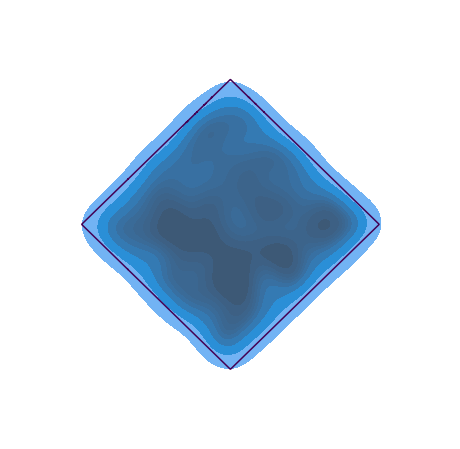

In [20]:
# density plot of prior distribution
lp = 1
constraint = 1
beta = priors(2, constraint, 5000, lp)
beta_x = beta.T[0]
beta_y = beta.T[1]
X = np.linspace(-1.5, 1.5, 1000)
Y = np.linspace(-1.5, 1.5, 1000)
zz = np.power(np.power(np.abs(xx), lp) + np.power(np.abs(yy), lp), 1/lp)
fig=plt.figure(figsize=(8,8))
plt.contour(X, Y, zz, [constraint])
sns.kdeplot(x = beta_x, y = beta_y, fill = True, levels = 10)
# plt.scatter(beta_true[0], beta_true[1], s = 10, c = 'r')
plt.axis('off')
plt.tick_params(labelsize=30)
plt.show()

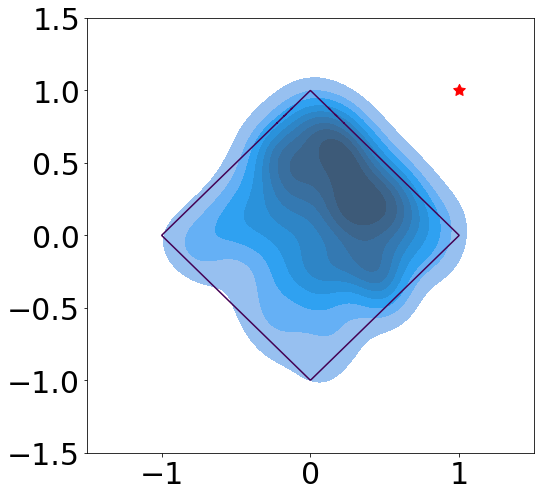

In [8]:
# density plot of PSGLD algorithm
import seaborn as sns
lp = 1
constraint = 1
beta_x = beta.T[0]
beta_y = beta.T[1]
X = np.linspace(-1.5, 1.5, 1000)
Y = np.linspace(-1.5, 1.5, 1000)
xx, yy = np.meshgrid(X, Y)
zz = np.power(np.power(np.abs(xx), lp) + np.power(np.abs(yy), lp), 1/lp)
fig=plt.figure(figsize=(8,8))
plt.contour(X, Y, zz, [constraint])
sns.kdeplot(x = beta_hist[0,-1,:,0], y = beta_hist[0,-1, :,1], fill = True, levels = 10)
plt.scatter(beta_true[0], beta_true[1], s = 150, c = 'r',marker=(5, 1))
# plt.axis('off')
plt.tick_params(labelsize=30)
plt.show()

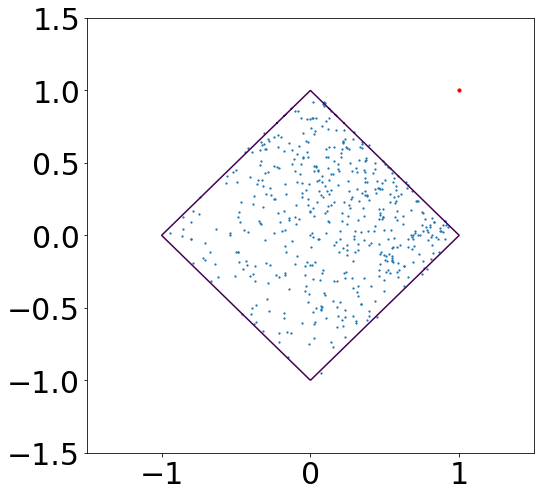

In [39]:
import seaborn as sns
lp = 1
constraint = 1
# beta = priors(2, constraint, 100, lp)
beta_x = beta.T[0]
beta_y = beta.T[1]
X = np.linspace(-1.5, 1.5, 1000)
Y = np.linspace(-1.5, 1.5, 1000)
xx, yy = np.meshgrid(X, Y)
zz = np.power(np.power(np.abs(xx), lp) + np.power(np.abs(yy), lp), 1/lp)
fig=plt.figure(figsize=(8,8))
plt.contour(X, Y, zz, [constraint])
plt.scatter(x = beta_hist[0,-1,:,0], y = beta_hist[0,-1, :,1], s = 1.5)
plt.scatter(beta_true[0], beta_true[1], s = 10, c = 'r')
# plt.axis('off')
plt.tick_params(labelsize=30)
plt.show()